<a href="https://colab.research.google.com/github/ysinjab/latent-glitch/blob/main/MeshRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd drive/MyDrive/artathon/facebookresearch/meshrcnn

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
%env FORCE_CUDA=1
!pip install -U torch==1.6 torchvision==0.7 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip install -U fvcore==0.1.3.post20210317
!pip install -U --force-reinstall iopath==0.1.6 
!pip install 'git+https://github.com/facebookresearch/detectron2.git@4b539e41f4b19570bc6b722fa0f516f927cdae02'
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# !ls

env: FORCE_CUDA=1
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 708.0 MB 10 kB/s 
     |████████████████████████████████| 5.9 MB 42.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0+cu101 which is incompatible.
     |████████████████████████████████| 47 kB 2.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58543 sha256=a4abc0aa1

## Imports and checking installation parameters


In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available(),torch.cuda.device_count())
!gcc --version
!python --version
!nvcc --version
!nvidia-smi
!python -m detectron2.utils.collect_env

1.6.0+cu101 True 1
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Python 3.7.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Thu Oct 21 22:29:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|=========

## Installing meshrcnn


In [5]:
!git clone https://github.com/facebookresearch/meshrcnn.git
!cd meshrcnn && pip install -e .

Cloning into 'meshrcnn'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 256 (delta 16), reused 31 (delta 13), pack-reused 210
Receiving objects: 100% (256/256), 136.48 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Obtaining file:///content/meshrcnn
  Running setup.py develop for meshrcnn


# Loading Pix3D Dataset
Also this import will take a while since it is loading the entire dataset 3.5GB


In [6]:
# pix3d data
# %cd /content/



In [7]:
# !git clone https://github.com/facebookresearch/meshrcnn.git

In [8]:
!./meshrcnn/datasets/pix3d/download_pix3d.sh

--2021-10-21 22:29:56--  http://pix3d.csail.mit.edu/data/pix3d.zip
Resolving pix3d.csail.mit.edu (pix3d.csail.mit.edu)... 128.52.128.175
Connecting to pix3d.csail.mit.edu (pix3d.csail.mit.edu)|128.52.128.175|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783261880 (3.5G) [application/zip]
Saving to: ‘pix3d.zip’

pix3d.zip           100%[===================>]   3.52G  15.4MB/s    in 4m 0s   

2021-10-21 22:33:57 (15.0 MB/s) - ‘pix3d.zip’ saved [3783261880/3783261880]

y
--2021-10-21 22:34:44--  https://dl.fbaipublicfiles.com/meshrcnn/pix3d/pix3d_s1_train.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781155 (4.6M) [text/plain]
Saving to: ‘pix3d_s1_train.json’

pix3d_s1_train.json 100%[===================>]   4.56M  3.20MB/s    in 1.4s    

2021-10-21 

In [34]:
from google.colab import files
uploaded = files.upload()  # import a rock from your computer and name it test.jpg

Saving 1.png to 1.png


## Demo (Inference)

In [41]:
# Running Demo on random image of the pix3d dataset, change according to your need (change 'test.jpg' to your file name)
# Be sure to upload the file on the correct folder

!python ./meshrcnn/demo/demo.py --config-file ./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml \
--input /content/test.jpeg --output output_demo --onlyhighest MODEL.WEIGHTS meshrcnn://meshrcnn_R50.pth

[10/22 01:00:59 demo]: Arguments: Namespace(config_file='./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml', focal_length=20.0, input='/content/test.jpeg', onlyhighest=True, opts=['MODEL.WEIGHTS', 'meshrcnn://meshrcnn_R50.pth'], output='output_demo')
/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()
[10/22 01:01:03 demo]: Predictions saved in output_demo/test


# Visualize the Picture Uploaded and the Segmentation Mask 

In [42]:
filename = 'test.jpeg' #check the name is the same as the file you uploaded
maskname = '0_mask_rock_1.000.png' # Make sure to change the file name with the appropriate mask change 'test/0_mask_rock_1.000.png'

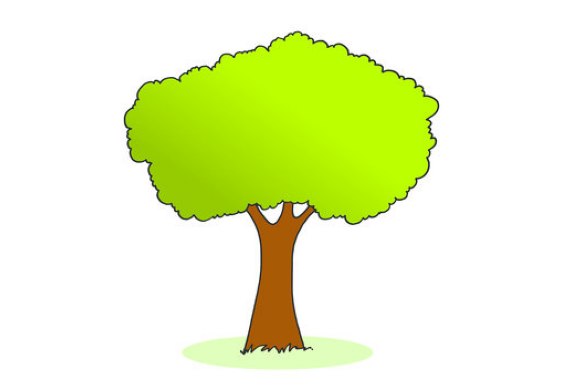

FileNotFoundError: ignored

<Figure size 720x720 with 0 Axes>

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

img = plt.imread("/content/" + filename) 
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
img = plt.imread("/content/output_demo/test/" + maskname)  
plt.imshow(img)
plt.axis('off')
plt.show()

# Download the .obj file

In [23]:
name = 'rock' # change file name accordingly

In [ ]:
!rm -rf /content/output_demo/test/


In [ ]:
from google.colab import files
files.download('/content/output_demo/test/0_mesh_'+ name + '_1.000.obj')

In [49]:
!ls

'=2.0.1'   meshrcnn   output_demo   sample_data   test.jpeg
